In [236]:
using DataFrames, GLM, Plots, Missings

These data numbers, were each collected via a simple Google search on Jan 17, 2024 with the search string "amount of data in the world in YYYY", where YYYY is the year. We only collected results for which Google displayed a summarizing string. The first two years, 2006, and 2007 were in etabytes, and the later in zetabytes (ZB). We converted everything to ZB. Some years presented the stored data and others the created data.

In [237]:
data = DataFrame(year = [2006, 2007, 2010, 2012, 2018, 2021, 2022],
                 created_data = [0.16, missing, 1.2, missing, 33, 79, 97 ],
                 stored_data = [missing, 0.29, missing, 2.8, missing, missing, missing])
data.year = data.year .- 2000; #change year to be since 2000 - needed for fitting exponential model
data

Row,year,created_data,stored_data
,Int64,Float64?,Float64?
1,6,0.16,missing
2,7,missing,0.29
3,10,1.2,missing
4,12,missing,2.8
5,18,33.0,missing
6,21,79.0,missing
7,22,97.0,missing


Fitting the model, $\log(y) = \beta_0 + \beta_1 x$, 

or $y = e^{\beta_0} e^{\beta_1 x} = K e^{\alpha x}$.

In [238]:
model_created = fit(LinearModel, @formula(log(created_data) ~ year), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(log(created_data)) ~ 1 + year

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -4.02624   0.323964   -12.43    0.0011  -5.05724   -2.99525
year          0.40158   0.0194651   20.63    0.0002   0.339633   0.463526
─────────────────────────────────────────────────────────────────────────

In [239]:
β0, β1 = coef(model_created);
K, α = exp(β0), β1

(0.01784121566761864, 0.40157956548341944)

Stored data at time t:

$$
\int_{-\infty}^t K e^{\alpha u} du = \frac{K}{\alpha} e^{\alpha t}
$$

It is just predicted at time $t$ divided by $\alpha$.

So can use these stored observations multiplied by the initial alpha estimate as other observations.

This is like a two stage analysis.

In [240]:
data[2,:created_data] = round(data[2,:stored_data]/α, digits = 2)
data[4,:created_data] = round(data[4,:stored_data]/α, digits = 2)
data

Row,year,created_data,stored_data
,Int64,Float64?,Float64?
1,6,0.16,missing
2,7,0.72,0.29
3,10,1.2,missing
4,12,6.97,2.8
5,18,33.0,missing
6,21,79.0,missing
7,22,97.0,missing


Now fit again.

In [241]:
model_created = fit(LinearModel, @formula(log(created_data) ~ year), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(log(created_data)) ~ 1 + year

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -3.31981    0.508708   -6.53    0.0013  -4.62749   -2.01214
year          0.371273   0.0338816  10.96    0.0001   0.284178   0.458368
─────────────────────────────────────────────────────────────────────────

In [242]:
β0, β1 = coef(model_created);
K, α = exp(β0), β1

(0.03615957973444979, 0.3712730333820715)

In [243]:
# Getting a bit more: See the ratio of created data to stored data. We have stored data web search results in 2007, and 2012. Let's see the predictions for these years:
pred_created(2007), pred_created(2012)

(0.48631333906767127, 3.1126144576944736)

In [244]:
pred_created(2007)/0.29, pred_created(2012)/2.8

(1.6769425485092113, 1.1116480206051693)

In [245]:
pred_created(year) = K*exp(α*(year-2000))
pred_stored(year) = (1/3) * pred_created(year)/α # Assume a third of the data is being kept

pred_stored (generic function with 1 method)

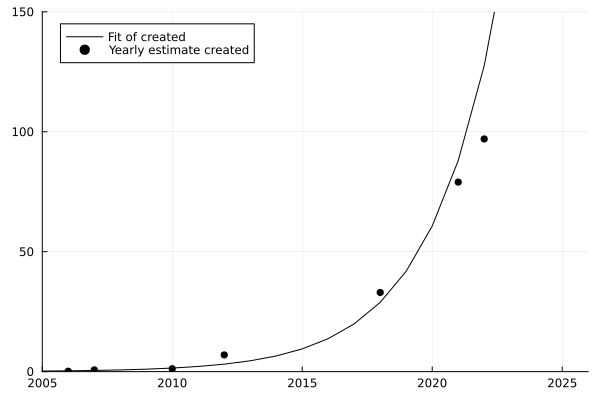

In [246]:
plot(2005:2025, pred_created.(2005:2025), lw = 1, label = "Fit of created", c = :black)
scatter!(dropmissing(data,:created_data).year .+ 2000, 
        dropmissing(data,:created_data).created_data,
        label = "Yearly estimate created", c = :black,
        xticks = 2000:5:2025, xlim = (2005, 2026), ylim = (0,150))

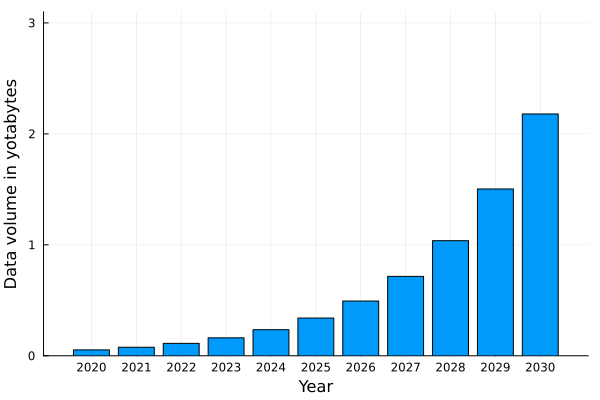

In [251]:
years = 2020:2030
yota_world = pred_stored.(years)/1024
bar(years,yota_world,xticks = years,label = :none,
    xlabel = "Year", ylabel = "Data volume in yotabytes",ylim = (0,3.1))

In [252]:
savefig("/Users/uqjnazar/Dropbox/MathEngDeepLearningBook/LaTeXBook/figures/chapter_1_figures/years_data_zb.pdf")

"/Users/uqjnazar/Dropbox/MathEngDeepLearningBook/LaTeXBook/figures/chapter_1_figures/years_data_zb.pdf"